In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py

# Modelling QENS dataset

## The Random-Jump diffusion model

In this workshop, we will be looking at how to model quasi-elastic neutron scattering (QENS) data based on an estimate of the diffusion coefficient, $D$, and random walk step size, $l$.
To achieve this, we will use the Random-Jump diffusion model <a href='https://doi.org/10.1080/00268978100100521' target='_blank'>[1]</a> which describes the variation of the structure factor, $S$, as a function of the energy transfer, $\omega$, and the wavevector, $q$. 

$$
S(\omega, q) = \frac{A}{\pi\gamma(q)\Big[1 + \big(\frac{\omega-\omega_0}{\gamma(q)}\big)^2\Big]},
$$

where $A$ is a scale factor, $\omega_0$ is the peak of the QENS curve, and, 

$$
\gamma(q) = \frac{6Dq^2}{1+l^2q^2}.
$$

The first thing that we will do is produce functions to enable the simulation a QENS dataset. 
Note, that there are other diffusion models that can be used to investigate QENS data, indeed there is the excellent [QENSmodels Python package](https://qensmodels.readthedocs.io) that includes a range of them, however, for simplicity we will focus on the Random-Jump model.

In [2]:
def gamma(q, D=0.091507, l=2.957):
    return 6 * D * q ** 2 / (1 + l ** 2 * q ** 2)

We can visualise what this will look like by plotting $\gamma(q)$ for the range $0.01 \leq q < 3 \mathrm{Å}^{-1}$, where $D = 0.091507 \mathrm{Å}^2\mathrm{meV}$ and $l=2.957 \mathrm{Å}$.

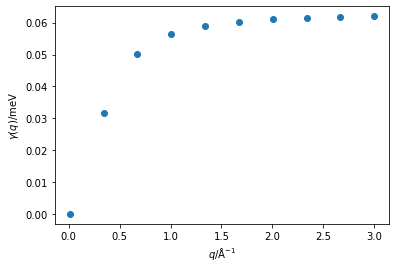

In [3]:
q = np.linspace(0.01, 2.9999, 10)
plt.plot(q, gamma(q), 'o')
plt.xlabel('$q$/Å$^{-1}$')
plt.ylabel('$\gamma(q)$/meV')
plt.show()

This function can then be used to produce an example of type of dataset that we measure with QENS, that is at a given $q$ we measure the structure factor, $S(\omega, q)$ as a function of energy transfer, $\omega$. 
To achieve this, we now need a function that will model the structure factor at a given $\omega$ and $q$, with inputs of $A$, $\omega_0$, $D$, and $l$. 

In [4]:
def structure_factor(omega, q, A=1, omega0=0, D=0.091507, l=2.957):
    g = gamma(q[:, np.newaxis], D, l)
    return A / (np.pi * g * (1 + ((omega - omega0) / g) ** 2))

Again for a range of $-1.5 \leq \omega \leq 1.5$, a $q$-value of $1\;\mathrm{Å}^{-1}$, where $A=1$, $\omega_0 = 0\;\mathrm{meV}$ and the same input values ($D$ and $l$) for the $q$-dependent relationship above, the following curve should be observed.

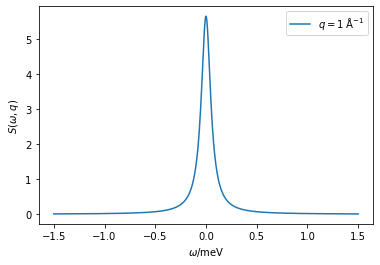

In [5]:
omega = np.linspace(-1.5, 1.5, 1000)
plt.plot(omega, structure_factor(omega, np.array([1]))[0], label='$q=1\;\mathrm{Å}^{-1}$')
plt.xlabel('$\omega$/meV')
plt.ylabel('$S(\omega, q)$')
plt.legend()
plt.show()

These two functions can be used together to plot the two dimensional QENS dataset. 

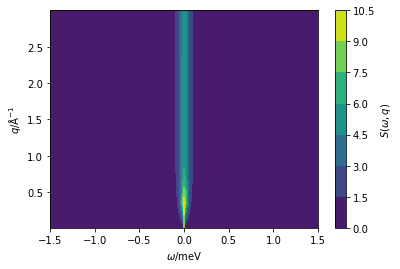

In [6]:
omegaq = np.meshgrid(omega, q)
plt.contourf(*omegaq, structure_factor(omega, q))
plt.xlabel('$\omega$/meV')
plt.ylabel('$q$/Å$^{-1}$')
plt.colorbar(label='$S(\omega, q)$')
plt.show()

The final element to include in our model of a QENS dataset is the instrumental resolution function. 
We obtain can obtain this from the measurement of a known sample and we store this data in an hdf5 file type. 
We read these as follows.

In [7]:
f = h5py.File('./data/resolution.hdf')

HDF5 files sort datasets in entries, we can find the resolution data in `'entry1/data1/DATA'` while the $q$ values and $\omega$ values are available in the `'entry1/data1/X'` and `'entry1/data1/Y'` entries respectively. 

In [8]:
resolution = f['entry1/data1/DATA'][:]
resolution /= resolution.sum()
omega = f['entry1/data1/X'][:]
q = f['entry1/data1/Y'][:]

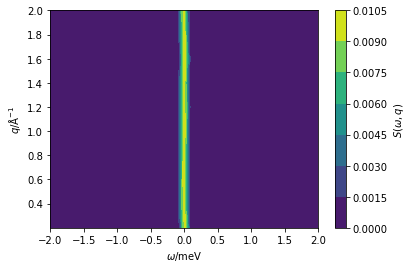

In [9]:
XY = np.meshgrid(omega, q)
plt.contourf(*XY, resolution)
plt.xlabel('$\omega$/meV')
plt.ylabel('$q$/Å$^{-1}$')
plt.colorbar(label='$S(\omega, q)$')
plt.show()

The full dataset can be constructed using the two dimensional convolution of the model and the resolution.

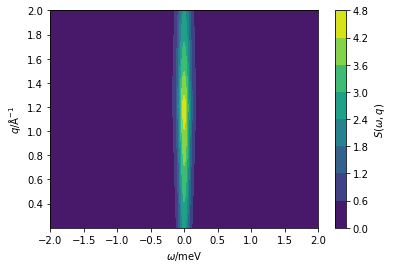

In [10]:
from scipy.signal import convolve2d
plt.contourf(*XY, convolve2d(structure_factor(omega, q), resolution, 'same'))
plt.xlabel('$\omega$/meV')
plt.ylabel('$q$/Å$^{-1}$')
plt.colorbar(label='$S(\omega, q)$')
plt.show()

## References

1. Hall, P. J. and Ross, D. K. [Incoherent neutron scattering functions for random jump diffusion in bounded and infinite media](https://doi.org/10.1080/00268978100100521). *Mol. Phys.*, **42**(3), 673-682.